# Dialogue Model Fine-Tuning - MELD Dating Simulator 🤖❤️

**Purpose:** Fine-tune LLaMA 3.1 for dating simulator with Friends character personas using pre-formatted MELD data

**Dataset Features:**
- 📊 ~1,500 pre-formatted dialogue pairs from MELD (romantic/dating conversations)
- 🎭 6 Friends characters with distinct personalities (Chandler, Monica, Ross, Rachel, Joey, Phoebe)
- 💕 Romantic/dating conversations only (filtered from MELD)
- 🎯 Emotion-conditioned responses (joy, sadness, anger, surprise, neutral, fear, disgust)
- 📝 LLaMA 3.1 chat template with system prompts (pre-formatted in notebook 02)
- 🔊 Speaker tokens included for persona learning

**What this notebook does:**
- 📚 Load pre-formatted LLaMA 3.1 instruction data (no parsing needed!)
- 🎯 Fine-tune LLaMA-3.1-8B with LoRA (memory efficient)
- 🎭 Train multi-persona dating simulator
- 📊 Monitor training with live visualizations
- 💾 Save and test your fine-tuned model

**Single GPU Optimizations:**
- LoRA: Train <1% of parameters
- Gradient checkpointing: Reduce memory by ~40%
- Mixed precision (FP16): 2x faster training
- Gradient accumulation: Simulate larger batch sizes

**Memory Requirements:** ~12-14GB for LLaMA-8B (your L40S has 47GB!)

---

## 1. Setup and Configuration

In [ ]:
!pip3 install torch
!pip3 install pandas
!pip3 install numpy
!pip3 install tqdm
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install transformers
!pip3 install datasets
!pip3 install accelerate
!pip3 install bitsandbytes
!pip3 install tensorboard
!pip3 install pyyaml
!pip3 install peft
!pip3 install --upgrade ipywidgets traitlets ipykernel tqdm

In [2]:
# Check environment
import sys
from pathlib import Path

# Add parent to path
if Path.cwd().name == 'notebooks':
    sys.path.insert(0, str(Path.cwd().parent))
    print("✓ Running from notebooks directory")
else:
    print(f"⚠️  Current directory: {Path.cwd()}")
    print("Please run from notebooks/ directory")

✓ Running from notebooks directory


In [ ]:
# Core imports
import torch
import json
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm
import glob
import re  # For parsing LLaMA 2 format and converting to LLaMA 3.1

# Transformers and PEFT
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    TaskType
)
from datasets import Dataset, DatasetDict

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'torch'

In [4]:
# GPU Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    
    # Clear cache
    torch.cuda.empty_cache()
else:
    print("⚠️  No GPU detected - training will be VERY slow")

Device: cuda
GPU: NVIDIA L40S
Memory: 47.67 GB
CUDA Version: 12.8


## 2. Training Configuration

**⚠️ CUSTOMIZE THESE SETTINGS:**

In [ ]:
# ==================== CONFIGURATION ====================

# Model settings
# MODEL_NAME = "meta-llama/Llama-2-7b-hf"  # LLaMA-2 base model for instruction tuning
MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"  # LLaMA-2 base model for instruction tuning
# Note: You'll need HuggingFace access token for LLaMA models

# Training mode
EMOTION_CONDITIONED = False  # Emotion already included in instruction prompts

# Data paths - instruction-formatted MELD data
DATA_PATH = "../../data/processed/MELD/meld_dating_sim_instruct.csv"
OUTPUT_DIR = "../../checkpoints/dating_sim_meld"

# Training hyperparameters
CONFIG = {
    # Data
    'max_length': 512,  # Longer for instruction format (was 256 for basic dialogue)
    'train_split': 0.9,  # 90% train, 10% validation
    
    # Training
    'num_epochs': 10,  # Start with 3, can increase if needed
    'batch_size': 1,  # Small for memory efficiency with long sequences
    'gradient_accumulation_steps': 8,  # Effective batch = 1 * 8 = 8
    'learning_rate': 2e-4,
    'warmup_steps': 100,
    'weight_decay': 0.01,
    
    # LoRA parameters
    'lora_r': 8,  # LoRA rank (higher = more params, better quality)
    'lora_alpha': 16,  # LoRA alpha (scaling factor)
    'lora_dropout': 0.05,
    'lora_target_modules': ['q_proj', 'v_proj', 'k_proj', 'o_proj'],  # Which layers to adapt
    
    # Memory optimization
    'gradient_checkpointing': True,
    'fp16': True,  # Use mixed precision
    'bf16': False,  # Use bfloat16 (better for newer GPUs like A100)
    
    # Logging
    'logging_steps': 10,
    'eval_steps': 100,
    'save_steps': 500,
    'save_total_limit': 3,  # Keep only 3 best checkpoints
}

print("Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Data: {DATA_PATH}")
print(f"  Output: {OUTPUT_DIR}")
print(f"  Max length: {CONFIG['max_length']} tokens (longer for instruction format)")
print(f"  Epochs: {CONFIG['num_epochs']}")
print(f"  Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")
print(f"\\n  🎭 Training Friends character personas for dating simulator!")

Configuration:
  Model: meta-llama/Llama-3.1-8B-Instruct
  Data: ../../data/processed/MELD/meld_dating_sim_instruct.csv
  Output: ../../checkpoints/dating_sim_meld
  Max length: 512 tokens (longer for instruction format)
  Epochs: 3
  Effective batch size: 8
\n  🎭 Training Friends character personas for dating simulator!


## 3. Load and Explore Data

In [3]:
# Load MELD instruction-formatted data
print(f"Loading data from: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

print(f"✓ Loaded {len(df)} training examples")
print(f"\nColumns: {list(df.columns)}")

# Data now has 'text' column with pre-formatted LLaMA 3.1 prompts
print(f"\nSample formatted prompt (first 500 chars):")
print("="*80)
print(df['text'].iloc[0][:500])
print("...")
print("="*80)

# Character/emotion stats (if columns exist)
if 'character' in df.columns:
    print(f"\nDataset statistics:")
    print(f"  Unique characters: {df['character'].nunique()}")
    print(f"  Characters: {', '.join(sorted(df['character'].unique()))}")
    
    if 'emotion' in df.columns:
        print(f"  Unique emotions: {df['emotion'].nunique()}")
        print(f"  Emotions: {', '.join(sorted(df['emotion'].unique()))}")
    
    print(f"\nCharacter distribution:")
    char_counts = df['character'].value_counts()
    for char, count in char_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {char:15s}: {count:5d} ({percentage:5.2f}%)")

Loading data from: ../../data/processed/MELD/meld_dating_sim_instruct.csv


NameError: name 'pd' is not defined

In [ ]:
# Calculate text lengths from formatted prompts
df['text_length_words'] = df['text'].str.split().str.len()
df['text_length_chars'] = df['text'].str.len()

print("Formatted Text Length Statistics:")
print("\nCharacter length:")
print(df['text_length_chars'].describe())
print("\nWord length:")
print(df['text_length_words'].describe())

# Visualize distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Text length distribution
ax.hist(df['text_length_chars'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax.set_xlabel('Characters in Formatted Prompt')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Formatted Prompt Lengths')
ax.axvline(CONFIG['max_length'] * 4, color='red', linestyle='--', label=f'~Max tokens*4: {CONFIG["max_length"]*4}')
ax.legend()

plt.tight_layout()
plt.show()

## 4. Skip Name Anonymization

MELD data for dating simulator uses Friends character names intentionally - they're part of the persona! Skipping anonymization.

In [ ]:
# Data is already instruction-formatted with personas!
# No anonymization needed - character names are part of the training

print("✓ Data already formatted with Friends character personas")
print(f"✓ Instruction prompts include:")
print(f"  - Character personality descriptions")
print(f"  - Dating scenario context")
print(f"  - User emotion labels")
print(f"  - Conversation history")
print(f"\\n✓ Ready for training!")

## 5. Create HuggingFace Dataset
 Convert anonymized dialogue pairs to HuggingFace Dataset format

In [ ]:
# Convert MELD instruction data to HuggingFace Dataset
# Data is already fully formatted in LLaMA 3.1 format with 'text' column

# Select only the text column (already has full LLaMA 3.1 formatting)
dataset_df = df[['text']].copy()

# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(dataset_df)

# Train/validation split
train_test = dataset.train_test_split(
    test_size=1-CONFIG['train_split'],
    seed=42
)

train_dataset = train_test['train']
val_dataset = train_test['test']

print(f"✓ Dataset created from {len(dataset)} pre-formatted examples")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")

# Show example
print(f"\\nExample training sample (first 400 chars of LLaMA 3.1 formatted text):")
print(train_dataset[0]['text'][:400] + "...")

## 6. Load Model and Tokenizer

In [ ]:
from huggingface_hub import login
login(token="") # TODO: Add your HuggingFace token here to access LLaMA models

In [ ]:
# Load tokenizer
print(f"Loading tokenizer: {MODEL_NAME}")

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
)

# Set padding token for LLaMA 3.1 (use EOS token)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
    print("✓ Set pad_token to eos_token")

print(f"✓ Tokenizer loaded")
print(f"  Vocab size: {len(tokenizer)}")
print(f"  Pad token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
print(f"  EOS token: {tokenizer.eos_token} (ID: {tokenizer.eos_token_id})")

In [ ]:
# Load base model
print(f"\nLoading model: {MODEL_NAME}")
print("This may take a few minutes...\n")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=torch.float16 if CONFIG['fp16'] else torch.bfloat16 if CONFIG['bf16'] else torch.float32,
    device_map='auto',  # Automatically distribute across available GPU(s)
    trust_remote_code=True
)

print("✓ Model loaded")

# Model info
total_params = sum(p.numel() for p in model.parameters())
print(f"  Total parameters: {total_params:,}")
print(f"  Size: ~{total_params * 2 / 1e9:.2f} GB (FP16)")


Loading model: meta-llama/Llama-2-7b-hf
This may take a few minutes...



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Model loaded
  Total parameters: 6,738,415,616
  Size: ~13.48 GB (FP16)


## 7. Configure LoRA

LoRA dramatically reduces trainable parameters and memory usage

In [28]:
# Prepare model for training
if CONFIG['gradient_checkpointing']:
    model.gradient_checkpointing_enable()
    print("✓ Gradient checkpointing enabled")

# LoRA configuration
lora_config = LoraConfig(
    r=CONFIG['lora_r'],
    lora_alpha=CONFIG['lora_alpha'],
    target_modules=CONFIG['lora_target_modules'],
    lora_dropout=CONFIG['lora_dropout'],
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Apply LoRA
model = get_peft_model(model, lora_config)

print("\n✓ LoRA applied")
model.print_trainable_parameters()

# Calculate memory savings
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMemory for trainable params: ~{trainable_params * 2 / 1e9:.3f} GB (FP16)")

✓ Gradient checkpointing enabled

✓ LoRA applied
trainable params: 8,388,608 || all params: 6,746,804,224 || trainable%: 0.1243

Memory for trainable params: ~0.017 GB (FP16)


## 8. Prepare Training Data

In [ ]:
def tokenize_function(examples):
    """
    Tokenize pre-formatted LLaMA 3.1 dialogues.
    
    Data is already fully formatted by notebook 02, so we just tokenize directly.
    """
    # Data is already in LLaMA 3.1 format, just tokenize
    tokenized = tokenizer(
        examples,  # List of pre-formatted text strings
        truncation=True,
        max_length=CONFIG['max_length'],  # 512 tokens for instruction format
        padding='max_length',
        return_tensors='pt'
    )
    
    # For causal LM, labels = input_ids
    tokenized['labels'] = tokenized['input_ids'].clone()
    
    return tokenized

# Test formatting
print("Example pre-formatted prompt (LLaMA 3.1, from notebook 02):")
print("="*80)
sample = train_dataset[0]
print(sample['text'][:600])  # Show first 600 chars
print("...")
print("="*80)
print("\\n✓ Data is already formatted - no parsing needed!")

In [ ]:
# Tokenize datasets
print("Tokenizing pre-formatted datasets...")

# Extract text from datasets
train_texts = [train_dataset[i]['text'] for i in range(len(train_dataset))]
val_texts = [val_dataset[i]['text'] for i in range(len(val_dataset))]

train_tokenized = tokenize_function(train_texts)
val_tokenized = tokenize_function(val_texts)

# Create torch datasets
class DialogueDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings['input_ids'])
    
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

train_torch_dataset = DialogueDataset(train_tokenized)
val_torch_dataset = DialogueDataset(val_tokenized)

print(f"✓ Tokenization complete")
print(f"  Train samples: {len(train_torch_dataset)}")
print(f"  Val samples: {len(val_torch_dataset)}")
print(f"\\n✓ No format parsing needed - data was pre-formatted in notebook 02!")

## 9. Configure Training

In [31]:
# Training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    
    # Training
    num_train_epochs=CONFIG['num_epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    per_device_eval_batch_size=CONFIG['batch_size'],
    gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
    
    # Optimization
    learning_rate=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    warmup_steps=CONFIG['warmup_steps'],
    lr_scheduler_type='cosine',
    
    # Memory optimization
    fp16=CONFIG['fp16'],
    bf16=CONFIG['bf16'],
    gradient_checkpointing=CONFIG['gradient_checkpointing'],
    
    # Logging and saving
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=CONFIG['logging_steps'],
    eval_steps=CONFIG['eval_steps'],
    save_steps=CONFIG['save_steps'],
    # save_total_limit=CONFIG['save_total_limit'],
    eval_strategy='steps',
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    
    # Other
    report_to='tensorboard',
    remove_unused_columns=False,
)

print("Training configuration:")
print(f"  Output dir: {OUTPUT_DIR}")
print(f"  Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")
print(f"  Total steps: {len(train_torch_dataset) // (CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']) * CONFIG['num_epochs']}")
print(f"  Mixed precision: {'FP16' if CONFIG['fp16'] else 'BF16' if CONFIG['bf16'] else 'FP32'}")

Training configuration:
  Output dir: ../checkpoints/dialogue_finetuned_v2
  Effective batch size: 64
  Total steps: 2280
  Mixed precision: FP16


In [ ]:
# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # We're doing causal LM, not masked LM
)

# Initialize early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.001
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_torch_dataset,
    eval_dataset=val_torch_dataset,
    data_collator=data_collator,
    callbacks=[early_stopping],
)

print("✓ Trainer initialized with early stopping")
print(f"  Early stopping patience: 3 evaluation steps")
print(f"  Will stop if validation loss doesn't improve for {3 * CONFIG['eval_steps']} training steps")

The model is already on multiple devices. Skipping the move to device specified in `args`.


✓ Trainer initialized


## 10. Start Training! 🚀

**Note:** This will take a while depending on your GPU and dataset size.

For LLaMA-7B on a 16GB GPU with these settings:
- Expected time: ~30-60 minutes per epoch
- Memory usage: ~12-14GB

In [33]:
# Clear GPU cache before training
import gc
gc.collect()
torch.cuda.empty_cache()

print("Starting training...")
print(f"Monitor progress in TensorBoard: tensorboard --logdir {OUTPUT_DIR}/logs")
print()

Starting training...
Monitor progress in TensorBoard: tensorboard --logdir ../checkpoints/dialogue_finetuned_v2/logs



In [34]:
# Train!
train_result = trainer.train()

print("\n" + "="*60)
print("Training Complete! 🎉")
print("="*60)
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")

Step,Training Loss,Validation Loss
100,1.938300,1.926156
200,1.891700,1.888800
300,1.850000,1.871513
400,1.808000,1.852875
500,1.800000,1.829071
600,1.716300,1.819015
700,1.676500,1.795494
800,1.669800,1.764564
900,1.551800,1.750042
1000,1.535800,1.724100



Training Complete! 🎉
Training loss: 1.4809
Training time: 14804.79 seconds


## 11. Save Model

In [35]:
# Save final model
final_model_path = f"{OUTPUT_DIR}/final"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"✓ Model saved to: {final_model_path}")

# Save training metrics
metrics_path = f"{OUTPUT_DIR}/training_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(train_result.metrics, f, indent=2)

print(f"✓ Metrics saved to: {metrics_path}")

✓ Model saved to: ../checkpoints/dialogue_finetuned_v2/final
✓ Metrics saved to: ../checkpoints/dialogue_finetuned_v2/training_metrics.json


## 12. Test the Model! 🎮

In [ ]:
# Set model to eval mode
model.eval()

def generate_response(character, user_input, emotion="neutral", scenario="You're on a casual coffee date.", max_new_tokens=128, temperature=0.9, top_p=0.9):
    """
    Generate a response as a Friends character using LLaMA 3.1.
    
    Args:
        character: Friends character name (Chandler, Monica, Ross, Rachel, Joey, Phoebe)
        user_input: What the user says
        emotion: User's emotion (joy, sadness, anger, surprise, neutral, fear, disgust)
        scenario: Dating scenario description
    """
    # Character personas (simplified)
    personas = {
        'Chandler': "You are Chandler Bing. You are witty and sarcastic.",
        'Monica': "You are Monica Geller. You are organized and competitive.",
        'Ross': "You are Ross Geller. You are intellectual and nerdy.",
        'Rachel': "You are Rachel Green. You are fashionable and fun.",
        'Joey': "You are Joey Tribbiani. You are confident and charming.",
        'Phoebe': "You are Phoebe Buffay. You are quirky and spiritual."
    }
    
    # Build system prompt
    persona_desc = personas.get(character, f"You are {character}.")
    system_content = f"{persona_desc}\nScenario: {scenario}\nThe user seems to be feeling: {emotion}"
    
    # Build messages for LLaMA 3.1 chat template
    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": user_input}
    ]
    
    # Apply chat template WITH generation prompt (adds assistant header)
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True  # Adds <|start_header_id|>assistant<|end_header_id|>
    )
    
    # Tokenize
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    
    # Generate with LLaMA 3.1 EOS token
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.convert_tokens_to_ids("<|eot_id|>")  # LLaMA 3.1 EOS
        )
    
    # Decode
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract response (everything after the last "assistant" marker)
    # The chat template creates: "...assistant\n\n{response}"
    if "assistant" in generated.lower():
        # Split and take the last part after "assistant"
        parts = re.split(r'assistant\s*', generated, flags=re.IGNORECASE)
        response = parts[-1].strip()
    else:
        # Fallback: just return the generated text
        response = generated.strip()
    
    return response

print("✓ Generation function ready (LLaMA 3.1)")
print("\nTest it with: generate_response('Chandler', 'Hi there!', 'joy')")

In [ ]:
# Test with different Friends characters
test_cases = [
    ("Chandler", "How are you doing today?", "joy"),
    ("Monica", "Want to grab dinner?", "neutral"),
    ("Ross", "Tell me about your interests", "neutral"),
    ("Rachel", "You look nice today", "joy"),
    ("Joey", "How you doin'?", "neutral"),
    ("Phoebe", "What do you believe in?", "neutral"),
]

print("Testing fine-tuned Friends dating simulator:\\n")
print("="*80)

for character, user_input, emotion in test_cases:
    response = generate_response(character, user_input, emotion)
    print(f"Character: {character}")
    print(f"User ({emotion}): {user_input}")
    print(f"Response: {response}")
    print("-"*80)

In [24]:
# Interactive testing
print("Interactive mode - Type 'quit' to exit\n")

while True:
    user_input = input("You: ")
    
    if user_input.lower() == 'quit':
        break
    
    response = generate_response(user_input)
    print(f"Bot: {response}\n")

IndentationError: unexpected indent (1969198136.py, line 8)

## 13. Training Visualization

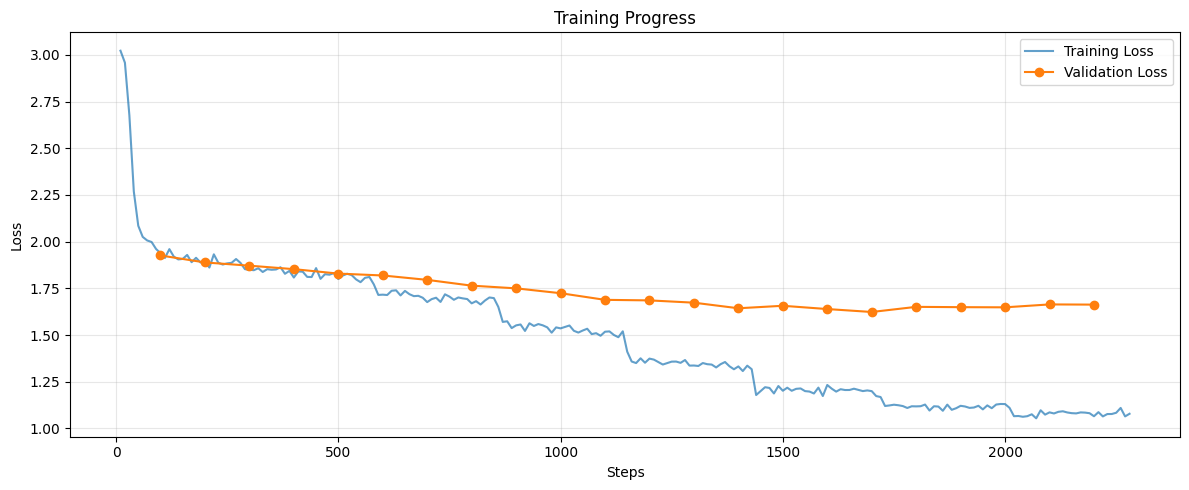

In [38]:
# Load training logs
import glob
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Find tensorboard logs
log_files = glob.glob(f"{OUTPUT_DIR}/logs/events.out.tfevents.*")

if log_files:
    event_acc = EventAccumulator(log_files[0])
    event_acc.Reload()
    
    # Extract training loss
    train_loss = event_acc.Scalars('train/loss') if 'train/loss' in event_acc.Tags()['scalars'] else []
    eval_loss = event_acc.Scalars('eval/loss') if 'eval/loss' in event_acc.Tags()['scalars'] else []
    
    if train_loss:
        # Plot losses
        fig, ax = plt.subplots(figsize=(12, 5))
        
        steps = [s.step for s in train_loss]
        values = [s.value for s in train_loss]
        ax.plot(steps, values, label='Training Loss', alpha=0.7)
        
        if eval_loss:
            eval_steps = [s.step for s in eval_loss]
            eval_values = [s.value for s in eval_loss]
            ax.plot(eval_steps, eval_values, label='Validation Loss', marker='o')
        
        ax.set_xlabel('Steps')
        ax.set_ylabel('Loss')
        ax.set_title('Training Progress')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No training metrics found in logs")
else:
    print("No TensorBoard logs found")

## 14. Next Steps 🎯

### What to do now:

1. **Test different characters:**
   ```python
   # Try all 6 Friends characters with different emotions
   generate_response('Chandler', "Tell me a joke", 'joy')
   generate_response('Monica', "Let's cook together", 'neutral')
   generate_response('Ross', "What's your favorite dinosaur?", 'joy')
   ```

2. **Build dating simulator interface:**
   - Create character selection menu
   - Add scenario customization
   - Implement conversation loop
   - Optional: Add emotion detection for user inputs

3. **Evaluate model quality:**
   - Check if Chandler responses are witty/sarcastic
   - Check if Monica responses are organized/competitive
   - Check if Ross responses are intellectual/nerdy
   - Verify emotion appropriateness (sad user → comforting response)

4. **Fine-tune further:**
   - Train for more epochs if needed (try 5-8)
   - Adjust LoRA rank for better quality (try r=16)
   - Experiment with generation parameters (temperature, top_p)

5. **Deploy:**
   - Create chatbot script with character selection
   - Add web interface (Gradio/Streamlit)
   - Implement memory/context tracking

### Dating Simulator Usage:

```python
# Basic dating sim loop
character = "Chandler"  # User picks character
scenario = "You're on a first date at Central Perk"

while True:
    user_input = input("You: ")
    if user_input == "quit":
        break
    
    # Optional: detect user emotion from input
    emotion = detect_emotion(user_input)  # or default to "neutral"
    
    response = generate_response(character, user_input, emotion, scenario)
    print(f"{character}: {response}")
```

### Troubleshooting:

**Responses too generic?**
- Train for more epochs
- Increase LoRA rank (r=16 or r=32)
- Check that instruction format is correct

**Out of Memory during generation?**
- Reduce `max_new_tokens`
- Set `temperature` lower (less sampling)

**Characters don't match personalities?**
- Check persona descriptions in instruction format
- Verify training data has good character distribution
- Try training longer (more epochs)